# Import necessary dependencies and settings

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200
%matplotlib inline

# Sample corpus of text documents

In [4]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


# Simple text pre-processing

In [5]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [6]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

# Word Embeddings

## Load up sample corpus - Bible

In [7]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


## Implementing a word2vec model using a CBOW (Continuous Bag of Words) neural network architecture

### Build Vocabulary

In [8]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('perceived', 1460), ('flagon', 7287), ('gardener', 11641), ('named', 973), ('remain', 732), ('sticketh', 10622), ('abstinence', 11848), ('rufus', 8190), ('adversary', 2018), ('jehoiachin', 3189)]


### Build (context_words, target_word) pair generator

In [8]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [9]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


### Build CBOW Deep Network Model

In [20]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 4, 100)            1242500   
_________________________________________________________________
lambda_2 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 12425)             1254925   
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


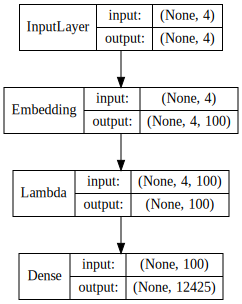

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

### Train model for 5 epochs

In [86]:
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 1 	Loss: 4257900.60084

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 2 	Loss: 4256209.59646

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 3 	Loss: 4247990.90456

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 4 	Loss: 4225663.18927

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 5 	Loss: 4104501.48929



### Get word embeddings

In [94]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
shall,-1.183386,-2.866214,1.046431,0.943265,-1.021784,-0.047069,2.108584,-0.458692,-1.698881,0.905800,...,0.655786,0.703828,0.821803,-0.093732,-2.474536,2.309505,0.713962,-0.175176,0.262700,0.818652
unto,-1.725262,-1.765972,1.411971,0.917713,0.793832,0.310631,1.541964,-0.082523,-1.346811,0.095824,...,1.682762,-0.872293,1.908597,0.977152,-0.835005,1.128618,0.834068,1.852117,-2.522386,-0.053387
lord,1.694633,-0.650949,-0.095796,0.950002,0.813837,1.538206,1.125482,-1.655581,-1.352673,0.409504,...,1.553925,-0.819261,1.086127,-1.545129,-0.035251,1.895598,2.378903,-1.632835,1.375105,0.599096
thou,-1.590623,-0.801968,1.659041,1.314925,-0.455822,1.733872,-0.233771,-0.638922,0.104744,0.490223,...,0.652781,-0.362778,-0.190355,0.040719,-1.988184,2.330042,1.441790,-1.771272,-1.738142,-3.210077
thy,0.386488,-0.834605,0.585985,0.801969,-0.165132,0.999917,1.224088,-0.317555,-0.671106,-1.073181,...,1.267184,-0.564660,0.089618,-0.979835,-0.215604,2.189568,0.529003,-1.682130,-0.632460,0.578122


### Build a distance matrix to view the most similar words (contextually)

In [95]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(12424, 12424)


{'egypt': ['destroy', 'none', 'whole', 'jacob', 'sea'],
 'famine': ['wickedness', 'sore', 'countries', 'cease', 'portion'],
 'god': ['therefore', 'heard', 'may', 'behold', 'heaven'],
 'gospel': ['church', 'fowls', 'churches', 'preached', 'doctrine'],
 'jesus': ['law', 'heard', 'world', 'many', 'dead'],
 'john': ['dream', 'bones', 'held', 'present', 'alive'],
 'moses': ['pharaoh', 'gate', 'jews', 'departed', 'lifted'],
 'noah': ['abram', 'plagues', 'hananiah', 'korah', 'sarah']}

## Implementing a word2vec model using a skip-gram neural network architecture

### Build Vocabulary

In [11]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('perceived', 1460), ('flagon', 7287), ('gardener', 11641), ('named', 973), ('remain', 732), ('sticketh', 10622), ('abstinence', 11848), ('rufus', 8190), ('adversary', 2018), ('jehoiachin', 3189)]


### Build and View sample skip grams ((word1, word2) -> relevancy)

In [16]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(james (1154), king (13)) -> 1
(king (13), james (1154)) -> 1
(james (1154), perform (1249)) -> 0
(bible (5766), dismissed (6274)) -> 0
(king (13), alter (5275)) -> 0
(james (1154), bible (5766)) -> 1
(king (13), bible (5766)) -> 1
(bible (5766), king (13)) -> 1
(king (13), compassion (1279)) -> 0
(james (1154), foreskins (4844)) -> 0


### Build Skip-gram Deep Network Model

In [22]:
from keras.layers import Merge
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Sequential

word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

model = Sequential()
model.add(Merge([word_model, context_model], mode="dot"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_3 (Merge)              (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 2,485,002
Trainable params: 2,485,002
Non-trainable params: 0
_________________________________________________________________
None


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


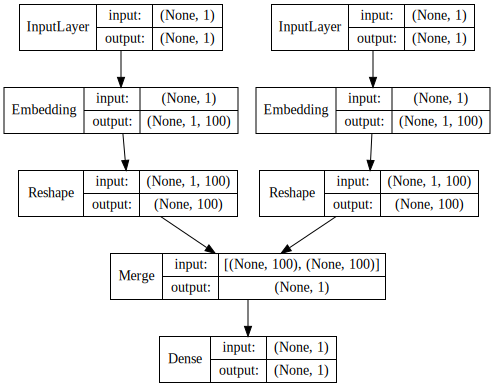

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

### Train the model for 5 epochs

In [43]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 4529.63803683
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 3750.71884749
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 3752.47489296
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 3793.9177565
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 3716.

### Get word embeddings

In [98]:
merge_layer = model.layers[0]
word_model = merge_layer.layers[0]
word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
shall,-0.002272,0.015870,0.018349,0.022802,0.028364,-0.040064,-0.013263,0.136607,0.019667,0.033407,...,0.037663,-0.087140,0.073169,-0.028257,0.085751,0.299031,0.123512,0.082310,0.243142,0.076125
unto,0.034425,-0.102070,0.018051,0.017960,0.172954,-0.115672,-0.012632,0.096919,-0.049203,-0.040344,...,0.106373,-0.075703,0.013888,-0.134224,0.132703,0.369338,0.149259,-0.031616,-0.069929,-0.136505
lord,0.051990,-0.113865,0.007226,0.031754,0.052963,-0.094523,-0.067664,0.001706,-0.112827,-0.078586,...,-0.041636,0.053685,0.041299,-0.026255,0.087085,0.253801,0.003064,0.128984,0.157639,-0.174654
thou,-0.152183,-0.073681,-0.091472,0.022033,0.008415,-0.048438,-0.041181,0.082019,0.004648,0.044870,...,0.101531,-0.018404,-0.070462,-0.041363,0.422717,0.320975,0.026026,0.179628,-0.026965,-0.151183
thy,-0.257579,-0.023008,0.053303,0.013690,-0.083293,0.034279,0.078811,0.079851,-0.015215,-0.111211,...,-0.064527,0.112085,0.061625,0.026398,0.164085,0.228056,0.031343,-0.009061,0.043006,-0.120782


### Build a distance matrix to view the most similar words (contextually)

In [99]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(12424, 12424)


{'egypt': ['pharaoh', 'mighty', 'houses', 'kept', 'possess'],
 'famine': ['rivers', 'foot', 'pestilence', 'wash', 'sabbaths'],
 'god': ['evil', 'iniquity', 'none', 'mighty', 'mercy'],
 'gospel': ['grace', 'shame', 'believed', 'verily', 'everlasting'],
 'jesus': ['christ', 'faith', 'disciples', 'dead', 'say'],
 'john': ['ghost', 'knew', 'peter', 'alone', 'master'],
 'moses': ['commanded', 'offerings', 'kept', 'presence', 'lamb'],
 'noah': ['flood', 'shem', 'peleg', 'abram', 'chose']}

### Visualize word embeddings

Total words: 48 	Word Embedding shapes: (48, 100)


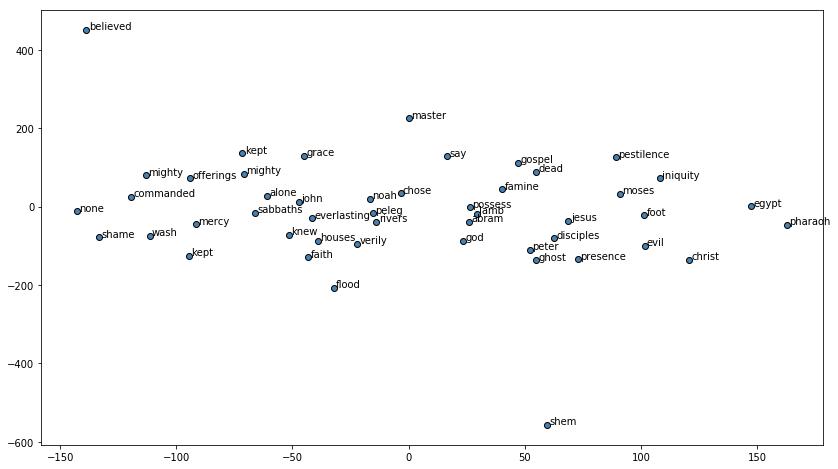

In [124]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Leveraging gensim for building a word2vec model

In [1065]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'egypt': ['pharaoh', 'egyptians', 'bondage', 'rod', 'flowing'],
 'famine': ['pestilence', 'peril', 'blasting', 'mildew', 'morever'],
 'god': ['lord', 'promised', 'worldly', 'glory', 'reasonable'],
 'gospel': ['faith', 'afflictions', 'christ', 'persecutions', 'godly'],
 'jesus': ['peter', 'messias', 'apostles', 'immediately', 'neverthless'],
 'john': ['baptist', 'james', 'peter', 'galilee', 'zebedee'],
 'moses': ['congregation', 'children', 'aaron', 'ordinance', 'doctor'],
 'noah': ['shem', 'japheth', 'ham', 'noe', 'henoch']}

## Visualizing word embeddings

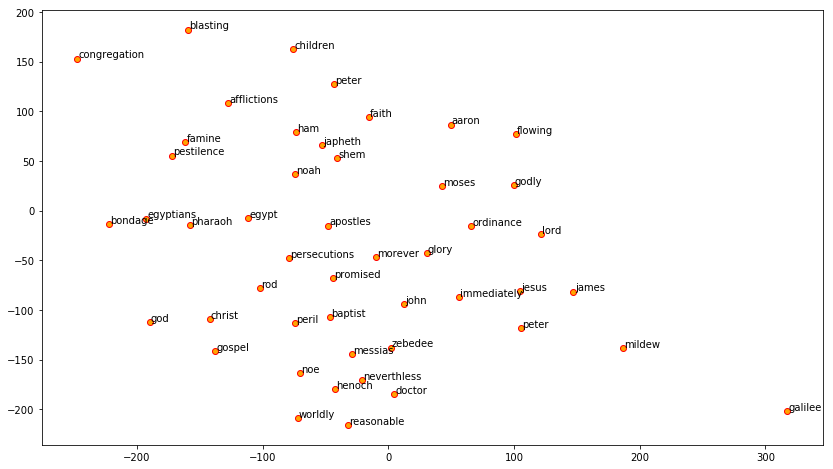

In [1080]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Applying the word2vec model on our sample corpus

In [79]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

## Visualize word embeddings

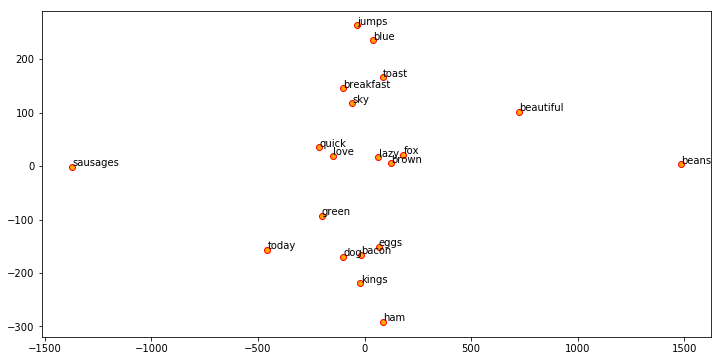

In [80]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Sample word embedding

In [81]:
w2v_model.wv['sky']

array([ 0.04576328,  0.02328374, -0.04483001,  0.0086611 ,  0.05173225,
        0.00953358, -0.04087641, -0.00427487, -0.0456274 ,  0.02155695], dtype=float32)

## Build framework for getting document level embeddings

In [82]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [83]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9
0,0.004690,0.009370,-0.009667,0.026014,0.034989,0.010402,-0.033441,-0.011956,-0.000243,0.010552
1,0.005751,0.003210,-0.001964,0.016550,0.030962,0.004340,-0.019463,-0.009149,0.008256,0.019600
2,0.016712,0.004806,-0.001924,-0.027226,0.029162,-0.017201,-0.023197,-0.008610,-0.011976,0.020602
3,-0.009216,0.003900,-0.009232,-0.005232,0.042718,-0.032432,-0.006243,0.013524,0.008095,0.021227
4,-0.016321,-0.008715,-0.001633,-0.000501,0.027367,-0.037861,0.008515,0.021066,0.020373,0.016512
5,0.018538,0.007522,-0.009302,-0.025440,0.037199,-0.009890,-0.021419,-0.011769,-0.002221,0.018277
6,0.008532,0.008041,-0.016573,0.018653,0.036140,0.004038,-0.022891,0.000484,-0.005900,0.015766
7,0.024419,0.012915,-0.010596,-0.039350,0.037018,-0.013378,-0.020677,-0.004417,-0.011864,0.013540


## Clustering with word embeddings

In [84]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beautiful today,weather,2
7,The dog is lazy but the brown fox is quick!,animals,1


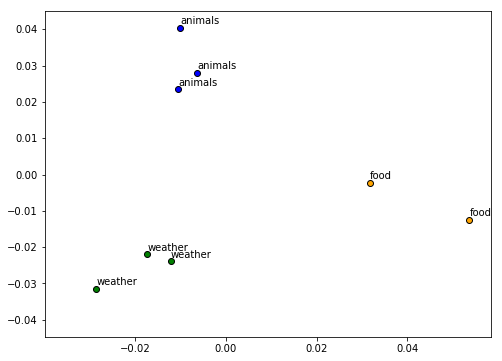

In [85]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

## GloVe Embeddings with spaCy

In [14]:
import spacy

nlp = spacy.load('en_vecs')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


## Visualize GloVe word embeddings

In [20]:
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
fox,-0.348680,-0.077720,0.177750,-0.094953,-0.452890,0.237790,0.209440,0.037886,0.035064,0.899010,...,-0.283050,0.270240,-0.654800,0.105300,-0.068738,-0.534750,0.061783,0.123610,-0.553700,-0.544790
ham,-0.773320,-0.282540,0.580760,0.841480,0.258540,0.585210,-0.021890,-0.463680,0.139070,0.658720,...,0.464470,0.481400,-0.829200,0.354910,0.224530,-0.493920,0.456930,-0.649100,-0.131930,0.372040
brown,-0.374120,-0.076264,0.109260,0.186620,0.029943,0.182700,-0.631980,0.133060,-0.128980,0.603430,...,-0.015404,0.392890,-0.034826,-0.720300,-0.365320,0.740510,0.108390,-0.365760,-0.288190,0.114630
beautiful,0.171200,0.534390,-0.348540,-0.097234,0.101800,-0.170860,0.295650,-0.041816,-0.516550,2.117200,...,-0.285540,0.104670,0.126310,0.120040,0.254380,0.247400,0.207670,0.172580,0.063875,0.350990
jumps,-0.334840,0.215990,-0.350440,-0.260020,0.411070,0.154010,-0.386110,0.206380,0.386700,1.460500,...,-0.107030,-0.279480,-0.186200,-0.543140,-0.479980,-0.284680,0.036022,0.190290,0.692290,-0.071501
eggs,-0.417810,-0.035192,-0.126150,-0.215930,-0.669740,0.513250,-0.797090,-0.068611,0.634660,1.256300,...,-0.232860,-0.139740,-0.681080,-0.370920,-0.545510,0.073728,0.111620,-0.324700,0.059721,0.159160
beans,-0.423290,-0.264500,0.200870,0.082187,0.066944,1.027600,-0.989140,-0.259950,0.145960,0.766450,...,0.048760,0.351680,-0.786260,-0.368790,-0.528640,0.287650,-0.273120,-1.114000,0.064322,0.223620
sky,0.312550,-0.303080,0.019587,-0.354940,0.100180,-0.141530,-0.514270,0.886110,-0.530540,1.556600,...,-0.667050,0.279110,0.500970,-0.277580,-0.143720,0.342710,0.287580,0.537740,0.363490,0.496920
bacon,-0.430730,-0.016025,0.484620,0.101390,-0.299200,0.761820,-0.353130,-0.325290,0.156730,0.873210,...,0.304240,0.413440,-0.540730,-0.035930,-0.429450,-0.246590,0.161490,-1.065400,-0.244940,0.269540
breakfast,0.073378,0.227670,0.208420,-0.456790,-0.078219,0.601960,-0.024494,-0.467980,0.054627,2.283700,...,0.647710,0.373820,0.019931,-0.033672,-0.073184,0.296830,0.340420,-0.599390,-0.061114,0.232200


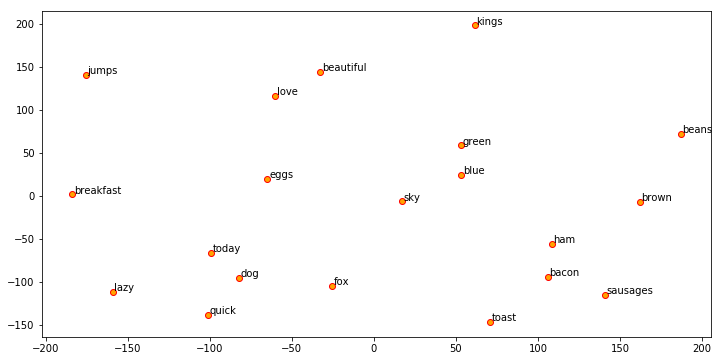

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Cluster documents with GloVe Embeddings

In [86]:
doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beautiful today,weather,2
7,The dog is lazy but the brown fox is quick!,animals,1


# Leveraging gensim for building a FastText model

In [9]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)


In [10]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'egypt': ['land', 'pharaoh', 'egyptians', 'pathros', 'assyrian'],
 'famine': ['pestilence', 'sword', 'egypt', 'dearth', 'blasted'],
 'god': ['lord', 'therefore', 'jesus', 'christ', 'truth'],
 'gospel': ['preached', 'preach', 'christ', 'preaching', 'gentiles'],
 'jesus': ['christ', 'god', 'disciples', 'paul', 'grace'],
 'john': ['baptist', 'baptize', 'peter', 'philip', 'baptized'],
 'moses': ['aaron', 'commanded', 'congregation', 'spake', 'tabernacle'],
 'noah': ['shem', 'methuselah', 'creepeth', 'adam', 'milcah']}

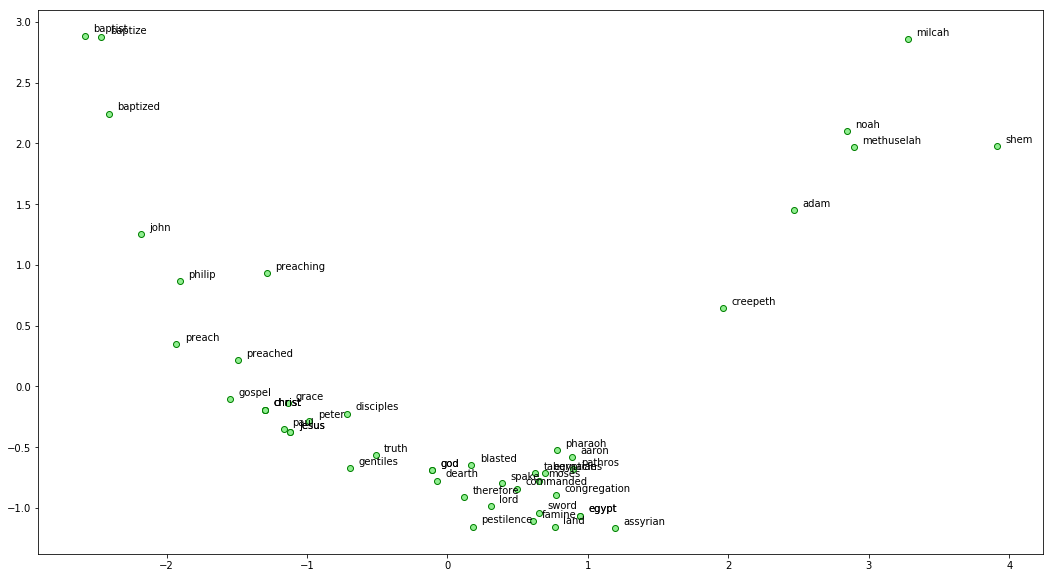

In [63]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [21]:
ft_model.wv['jesus']

array([-0.23493268,  0.14237943,  0.35635167,  0.34680951,  0.09342121,
        0.11546664,  0.06848907, -0.35488272,  0.03399122,  0.26420799,
        0.05554794, -0.41830763, -0.38671952,  0.38901171, -0.26265353,
        0.03854577, -0.22641954,  0.16377565, -0.0347381 , -0.43721643,
       -0.18751772,  0.03163779,  0.12475108,  0.28285024,  0.11760047,
       -0.24720524, -0.25686634, -0.01248573,  0.10454553,  0.29713026,
       -0.04111641, -0.44567475, -0.14127477, -0.20297718,  0.05123538,
       -0.19558378, -0.24215269, -0.22690177,  0.45923024,  0.10298209,
        0.07537983,  0.23333244, -0.34262201,  0.36080933, -0.05114703,
       -0.19241138, -0.46164852, -0.25011861, -0.25578389, -0.11737192,
        0.05247249, -0.00788139, -0.4545919 ,  0.0890988 , -0.58961135,
       -0.15117864,  0.25921214,  0.50884134, -0.03514979, -0.48242396,
       -0.20581312,  0.1193359 ,  0.02668546,  0.22564436, -0.00703725,
        0.34001571, -0.19389269, -0.59574127,  0.13655224, -0.44

In [53]:
print(ft_model.wv.similarity(w1='god', w2='satan'))
print(ft_model.wv.similarity(w1='god', w2='jesus'))

0.333260876685
0.698824900473


In [36]:
st1 = "god jesus satan john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "john peter james judas"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ god jesus satan john ]: satan
Odd one out for [ john peter james judas ]: judas
